In [2]:
import os
from os.path import join, basename, dirname
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# import plotly #allows interactive plotting
# import contextily as ctx # back ground maps
from osgeo import gdal # need to import first for rasterio
import rasterio
import shapely

from shapely.ops import linemerge
from shapely.geometry import LineString, Point, shape, mapping
import fiona


In [3]:
usr_dir = os.getcwd()
while basename(usr_dir) != 'Users':
    temp = basename(usr_dir)
    usr_dir = dirname(usr_dir)
usr_dir += '/' + temp

gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel/'

proj_dir = gwfm_dir+'Stream_seepage/'
dat_dir = proj_dir+'Stream_level_data/'

In [4]:

dem_dir = gwfm_dir+ '/DEM_data'



In [5]:
# raster_name = dem_dir+'/USGS_ten_meter_dem/regional_10m.tif'
# raster_name = dem_dir+'/USGS_one_meter_dem/cropped_dem.tif'
# raster_name = dem_dir+'/HECRAS_dem/Terrain.Cos.tif'
# load 1M DEM
raster_name = dem_dir+'/HECRAS_dem/Terrain.Cos.reprojected.tif'
conv = 0.3048 # for hec-ras DEM, ft to meters

# Quick Map of Loggers

<AxesSubplot: >

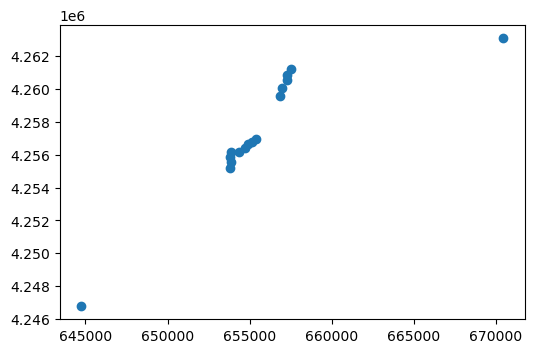

In [6]:
df = pd.read_csv(dat_dir+'/instream_sensor_latlong.csv')
rm_sp = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude,df.Latitude))
rm_sp.crs = 'epsg:4326'
rm_sp = rm_sp.to_crs('epsg:32610')

fig, ax =plt.subplots(figsize=(6,6))
rm_sp.plot(ax=ax)
# USGS. USImagery, USImageryTopo, USTopo; Esri. WorldImagery, WorldTopoMap
# ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs='epsg:26910', attribution=False)


# Get elevation of logger locations

In [7]:

dem_f = rasterio.open(raster_name)
dem = dem_f.read(1)
xmin, xmax = dem_f.bounds[0], dem_f.bounds[2]
ymin, ymax = dem_f.bounds[1], dem_f.bounds[3]
 
# crop in-stream sensors to those covered by the 1m DEM
rm_t = rm_sp.cx[xmin:xmax, ymin:ymax]
rm_t['Easting'] = rm_t.geometry.x.values
rm_t['Northing'] = rm_t.geometry.y.values

point = rm_t.loc[:,['Easting','Northing']].values

with rasterio.open(raster_name) as src:
    rm_t['z_ft'] = [sample[0] for sample in src.sample(point)]

rm_t['z_m'] = rm_t.loc[:,'z_ft']*conv


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set 

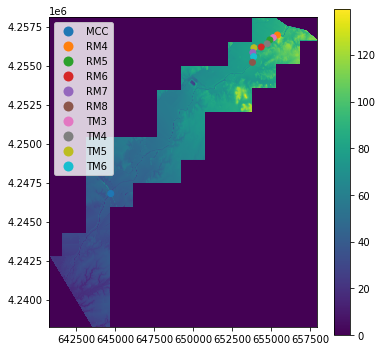

In [8]:
fig,ax=plt.subplots(figsize=(6,6))
rm_t.plot('Sensor', ax=ax, legend=True)

im = ax.imshow(dem, extent = [xmin,xmax,ymin,ymax],vmin=0)
fig.colorbar(im)

# plt.xlim(cr_xmin, cr_xmax )
# plt.ylim(cr_ymin, cr_ymax )

## Crop analysis to area with 1m DEM (Teichert to MCC)

In [9]:
# remove McConnell from teichert locations
rm_t = rm_t.loc[rm_t.Sensor != 'MCC']

# limit analysis to boundary box of stream sensors
cr_xmin, cr_ymin, cr_xmax, cr_ymax = rm_t.buffer(400).total_bounds


In [ ]:
# Rivers and creeks in the larger area encompassing Cosumnes River in both South American and Cosumnes Subbasins
rivers = gpd.read_file(gwfm_dir+"/SFR_data/Sac_valley_rivers/Sac_valley_rivers.shp")
rivers = rivers.to_crs('EPSG:32610')
cr = rivers[rivers.GNIS_Name =='Cosumnes River']
# filter to DEM extents
cr = cr.cx[xmin:xmax, ymin:ymax]

# Stream segments, there is a new segment each time two rivers/creeks join one another
cr_line = shapely.geometry.MultiLineString(cr.geometry.values)


<AxesSubplot: >

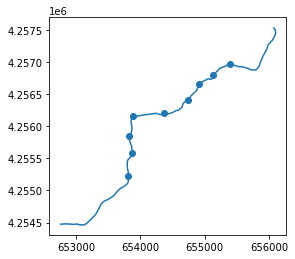

In [11]:
cr.cx[cr_xmin:cr_xmax, cr_ymin:cr_ymax].length.sum()/100
fig,ax = plt.subplots()
cr.cx[cr_xmin:cr_xmax, cr_ymin:cr_ymax].plot(ax=ax)
rm_t.plot(ax=ax)

# Get elevation of "thalweg"
Thalweg here is elevation at shapefile location.

In [7]:

# alternate raster
raster_name = dem_dir+'/mwt_peri_2_3.tif/mwt_peri_2_3_clipped.tif'
proj_dir = gwfm_dir+'Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

# raster_name = gwfm_dir+"/DEM_data/USGS_ten_meter_dem/modeldomain_10m_transformed.tif"
# proj_dir = gwfm_dir+'SFR_data/'
# dat_dir = proj_dir+'Stream_level_data/'

conv = 1 # for other dem, keep meters


In [8]:
dem_f = rasterio.open(raster_name)
# dem = dem_f.read(1)
xmin, xmax = dem_f.bounds[0], dem_f.bounds[2]
ymin, ymax = dem_f.bounds[1], dem_f.bounds[3]
 
# Rivers and creeks in the larger area encompassing Cosumnes River in both South American and Cosumnes Subbasins
rivers = gpd.read_file(gwfm_dir+"/SFR_data/Sac_valley_rivers/Sac_valley_rivers.shp")
# rivers = gpd.read_file(gwfm_dir+"/SFR_data/NHD_MajorRivers/NHD_MajorRivers.shp")
# cr = rivers[rivers.GNIS_Name=='Cosumnes River']

rivers = rivers.to_crs('EPSG:32610')
cr = rivers[rivers.GNIS_Name =='Cosumnes River']
# filter to DEM extents
cr = cr.cx[xmin:xmax, ymin:ymax]
cr['temp_id'] = np.arange(0,len(cr)) # id to track original order to final

# Stream segments, there is a new segment each time two rivers/creeks join one another
cr_line = shapely.geometry.MultiLineString(cr.geometry.values)


In [9]:
# linemerge is essential because it joins linesegments by matching (x,y) so the line is continuous
geom = linemerge(cr.geometry.unary_union)

# # length of the LineString
length = int(geom.length)
sfr_sp = gpd.GeoDataFrame(pd.DataFrame(np.zeros((length,1)),columns=['id']))
sfr_sp['geometry'] = shapely.geometry.Point(0,0)
# enumerate keeps track of the count in addition to the object being iterated on
for i, distance in enumerate(range(0, length, 1)):
    point = geom.interpolate(distance)
    sfr_sp.loc[i,'geometry'] = point
    sfr_sp.loc[i,'id'] = i

In [10]:
sfr_sp['Easting'] = sfr_sp.geometry.x.values
sfr_sp['Northing'] = sfr_sp.geometry.y.values

point = sfr_sp.loc[:,['Easting','Northing']].values

with rasterio.open(raster_name) as src:
    sfr_sp['z_ft'] = [sample[0] for sample in src.sample(point)]
    
sfr_sp['z_m'] = sfr_sp.loc[:,'z_ft']*conv


## Convert the parallel lines to points 

In [289]:
# using lengths on the parallel lines won't work because around bends one will become offset
# one option is to pick a point on the line to interpolate and pick one point a little further 
# then do parallel offset to that line and create the transect that way

In [11]:

geom = linemerge(cr.geometry.unary_union)

# geom = geom.simplify(10)
# how often to interpolate a point
# since small-scale flow data isn't in use 200 m is fine
dline = 100
# # length of the LineString
length = int(geom.length)

transects = pd.DataFrame(np.zeros((int(np.ceil(length/dline)),1)), columns = ['line'])
transects['geometry'] = LineString([(0,0),(0,1)]) #initiate LineString geometry column

# 300 meter width so that 100 meter can be cutoff to have 200m around true thalweg
xs_width = 300
for i, distance in enumerate(np.arange(0, int(length), dline)):
    short_line = LineString([geom.interpolate(distance),geom.interpolate(distance+dline)])
    geom_left = short_line.parallel_offset(xs_width/2,'left', resolution = 32, join_style = 2)
    geom_right = short_line.parallel_offset(xs_width/2,'right', resolution = 32, join_style = 2)
    # old method was geom_left.boundary but broke with update
    perp_line = LineString([list(geom_left.coords)[0], list(geom_right.coords)[0]])
    transects.loc[i,'geometry'] = perp_line

<AxesSubplot: >

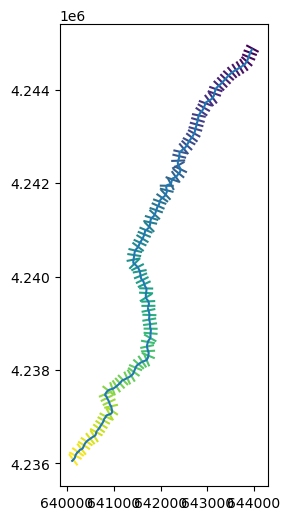

In [12]:
transg = gpd.GeoDataFrame(transects)
transg = transg.drop_duplicates('geometry')
transg['line'] = np.arange(0,len(transg))
# check cross section lines are paralle
fig,ax=plt.subplots(figsize=(6,6))
transg.plot('line',ax=ax)
cr.plot(ax=ax)

## Sample elevations for each point
Can sample elevation by converting all lines to points then sampling each point or by sampling one line at a time.

In [295]:
# # how often to interpolate a point in a XS
dline = 1

xs_all = gpd.GeoDataFrame(pd.DataFrame(columns=['xs_num','dist_from_right_m','geometry']))
xs = gpd.GeoDataFrame(pd.DataFrame(np.zeros((int(xs_width/dline),2)), columns=['xs_num','dist_from_right_m']))


for j in np.arange(0,len(transg)):
    xs['geometry'] = Point([(0,0)])
    xs['xs_num'] = j
    
    # pick one geometry at a time
    geom = transg.iloc[j].geometry

    # # # length of the LineString
    length = int(geom.length)
    # create discrete points for each lien
    for i, distance in enumerate(range(0, int(length), dline)):
        point = geom.interpolate(distance)
        xs.loc[i,'geometry'] = point
        xs.loc[i,'dist_from_right_m'] = i
    # append individual cross section to all dataframe
    xs_all = pd.concat((xs_all, xs))

In [296]:
xs_all.crs='epsg:32610'
xs_all['Easting'] = xs_all.geometry.x
xs_all['Northing'] = xs_all.geometry.y
point = xs_all.loc[:,['Easting','Northing']].values

with rasterio.open(raster_name) as src:
    xs_all['z_ft'] = [sample[0] for sample in src.sample(point)]

xs_all['z_m'] = xs_all.loc[:,'z_ft']*conv



In [297]:

# remove any NA values picked up from DEM raster
xs_all.loc[xs_all['z_ft']==dem_f.nodata,['z_ft','z_m']] = np.nan
xs_all.index = np.arange(0,len(xs_all))

# need to drop XS where there are a lot of NAs (>250)
xs_num_full = xs_all.xs_num.unique()[(xs_all.groupby('xs_num').count()['z_ft']>250).values]
xs_all = xs_all[xs_all.xs_num.isin(xs_num_full)]

# clean xs to only center 200 m out from true thalweg rather than NHD line
xs_all_cln = gpd.GeoDataFrame()
# correct XS points by those that were chosen for final XS
for n in xs_all.xs_num.unique():
    mid = xs_all.loc[xs_all.xs_num==n,'z_m'].iloc[int(xs_width/2)-50:int(xs_width/2)+50].idxmin()
    mid_vals = xs_all.loc[mid-100:mid+99]
    xs_all_cln = pd.concat((xs_all_cln,mid_vals))
# clean up distance from right
xs_all_cln['dist_from_right_m'] = np.tile(np.arange(0,200), len(xs_all_cln.xs_num.unique()))


In [298]:
# convert to dataframe for creating table of XS
xs_all_df = pd.DataFrame(xs_all_cln.copy())
# pivot based on XS number and save only elevation in z_m
xs_all_df = xs_all_df.pivot_table(index='dist_from_right_m',columns='xs_num',values='z_m')


In [299]:
dat_dir

'C:\\Users/ajcalder/Box/research_cosumnes/GWFlowModel/Oneto_Denier/Stream_level_data/'

In [300]:
# save point data and XS
xs_all_cln.drop(['geometry'],axis=1).to_csv(dat_dir+'/XS_point_elevations.csv')
xs_all_df.to_csv(dat_dir+'/Elevation_by_XS_number_meters.csv')
